In [1]:
import copy
import sys
import math, random, numpy as np
import json
import datetime
from pathlib import Path
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torchvision import models, transforms as T
from torchvision.utils import make_grid

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import normalized_mutual_info_score
from tqdm import tqdm

import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
import h5py
from sklearn.manifold import TSNE
import time

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from deep_clastering.datasets import LogatecDataset, LabeledGhentDataset, LabeledITSDataset 
from deep_clastering.cnn import AE_CNN_1D
from deep_clastering.visualization import get_averaged_clusters, plot_averaged_clusters_spectograms
from deep_clastering.visualization import plot_tsne, plot_labels_dist_across_clusters

In [4]:
# Setup GPU

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = False
    pin_memory = True
else:
    device = torch.device('cpu')
    pin_memory = False

print("Current device: ", torch.cuda.current_device())  
print("Current device: ", torch.cuda.is_available())  

Current device:  0
Current device:  True


In [5]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [6]:
def distance_based_clustering_loss(features:torch.Tensor, clusters_centres:torch.Tensor):
    """
    H. Zhou, J. Bai, Y. Wang, J. Ren, X. Yang, and L. Jiao, “Deep radio
    signal clustering with interpretability analysis based on saliency map" 2023
    Algorithm 1
    
    Train weighted distances between samples and clusters centres.
    
    Weights are calculated to give the biggest penalty 
    to distance between a sample and it's nearest cluster. Weights are not trainable
    """
    num_clusters = clusters_centres.shape[0]
    num_samples = features.shape[0]
    
    # (num_clusters, num_samples, num_features)
    
    features = features.unsqueeze(0).repeat(num_clusters, 1, 1)
    clusters_centres = clusters_centres.unsqueeze(1).repeat(1,num_samples,1)
    
    distances = ((features - clusters_centres)**2).sum(axis = 2)
        
    min_distances, _ = distances.detach().min(dim=0)
    
    min_distances = min_distances.unsqueeze(0).repeat(num_clusters, 1)
    
    exp_shifted_distances = torch.exp(-(distances - min_distances)).detach()
    
    exp_shifted_distances_sums = exp_shifted_distances.sum(axis = 0)
    
    weighted_distances = distances * exp_shifted_distances / exp_shifted_distances_sums
    
    return weighted_distances.mean()

KLDiv_clustering_loss = nn.KLDivLoss()

In [7]:
class ClusterlingLayer(nn.Module):
    """
    Clustering layer definition (see DCEC article for equations)
    """
    def __init__(self, in_features=10, out_features=10, alpha=1.0):
        super(ClusterlingLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        self.weight = nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        x = x.unsqueeze(1) - self.weight
        x = torch.mul(x, x)
        x = torch.sum(x, dim=2)
        x = 1.0 + (x / self.alpha)
        x = 1.0 / x
        x = x ** ((self.alpha +1.0) / 2.0)
        x = torch.t(x) / torch.sum(x, dim=1)
        x = torch.t(x)
        return x

    def extra_repr(self):
        return 'in_features={}, out_features={}, alpha={}'.format(
            self.in_features, self.out_features, self.alpha
        )

    def set_weight(self, tensor):
        self.weight = nn.Parameter(tensor)

# Function forwarding data through network, collecting clustering weight output and returning prediciotns and labels
def calculate_predictions(model, clustering_layer, dataset, train_config):
    
    dataloader = DataLoader(
        dataset, 
        num_workers=train_config['num_workers'], 
        batch_size=train_config['batch_size'], 
        shuffle=True)
    
    probs_array = []
    label_array = []
    preds = []
    
    model.eval()
    clustering_layer.eval()
    
    for data in dataloader:
        
        inputs, labels = data
        inputs = inputs.to(train_config['device'])
        labels = labels.to(train_config['device'])
        
        outputs, features = model(inputs)
        probs = clustering_layer(features)
        
        probs_array.append(probs.detach().cpu())
        label_array.append(labels.cpu().detach())
        
    probs_array = torch.cat(probs_array).numpy()
    
    label_array = torch.cat(label_array).numpy()
    
    preds = np.argmax(probs_array, axis=1)
    
    return probs_array, label_array, preds

def cacl_target_dist(out_distr):
    tar_dist = out_distr ** 2 / np.sum(out_distr, axis=0)
    tar_dist = np.transpose(np.transpose(tar_dist) / np.sum(tar_dist, axis=1))
    return tar_dist

In [8]:
def extract_features(model:nn.Module, dataset:Dataset, train_config:dict)->torch.Tensor:
    num_workers = train_config['num_workers']
    batch_size = train_config['batch_size']
    data_loader = DataLoader(dataset, 
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)
    model.eval()
    features_list = []
    for imgs, label in data_loader:
        output, features = model(imgs.to(device))
        features_list.append(features.detach().cpu())
    
    return torch.cat(features_list)
    

In [9]:
def train(
    model, 
    dataset,
    criterion_reconstruction, 
    scheduler, 
    optimizer, 
    train_config
):
    num_warmup_epochs = train_config['num_warmup_epochs']
    num_train_epochs = train_config['num_train_epochs']
    
    num_workers = train_config['num_workers']
    batch_size = train_config['batch_size']
    
    num_clusters = train_config['num_clusters']
    clustres_centers = None
    target_distribution = None
    clastering_layer = None
    
    num_epochs_update_target_dist = train_config.get('update_target_dist_epochs')
    
    clastering_loss_type = train_config['clustring_loss_type']
    clustering_loss_coeff = train_config['clustering_loss_coeff']

    
    if hasattr(dataset, 'name'):
        dataset_name = dataset.name
    else:
        dataset_name = 'unknown_data'

    if hasattr(model, 'name'):
        model_name = model.name
    else: 
        model_name = 'unknown_model'
    
    dataloader = DataLoader(dataset, 
                            batch_size=batch_size, 
                            num_workers=num_workers,
                            shuffle=False)
    
    
    init_time = time.time()

    
    d_t_string = datetime.datetime.now().strftime("%H_%M_%S_%d_%m_%Y")
    
    SAVE_MODEL_PATH = (
        f"/results/models/{model_name}_{dataset_name}_e_warm{num_warmup_epochs}"
        f"_e_train{num_train_epochs}_coeff_{clustering_loss_coeff}_"
        f"{clastering_loss_type}_{d_t_string}.pt")
    
    epoch_losses = []
    c_epoch_losses = []
    
    
    for epoch in range(num_warmup_epochs + num_train_epochs):
        print('training: \t Epoch {}/{}'.format(epoch + 1, num_warmup_epochs+ num_train_epochs))
    
        model.train(True)

        running_loss = 0.0
        
        # Keep the batch number for inter-phase statistics
        batch_num = 1
        
        # Images to show
        img_counter = 0
        c_running_loss = 0
        
        # Progress bar for easier tracking of the status
        pbar = tqdm(dataloader, desc='training', unit='batch')
        
        times = []
        
        if epoch == num_warmup_epochs:
            #init clusters_centres
            
            if clastering_loss_type == 'distance_based':
                
                kmeans = MiniBatchKMeans(n_clusters=num_clusters, 
                                          batch_size=256, 
                                          init_size=3*train_config['num_clusters'], 
                                          n_init=3)
                
                features = extract_features(model, dataset, train_config)
                kmeans.fit_predict(features)
                init_clusters = kmeans.cluster_centers_
                clustres_centers = torch.from_numpy(init_clusters).to(device)
                
            if clastering_loss_type == 'KLDivLoss':
                clastering_layer = ClusterlingLayer()
                clastering_layer.to(device)

        # update tagret distr
        if (epoch >= num_warmup_epochs and 
            clastering_loss_type == 'KLDivLoss' and
            (epoch - num_warmup_epochs) % num_epochs_update_target_dist == 0):
            output_distribution, labels, preds =\
            calculate_predictions(model, clastering_layer, dataset, train_config)
                
            target_distribution = cacl_target_dist(output_distribution)
                
        # Iterate over data.
        for inputs, labels in pbar:

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            outputs, features = model(inputs)
            loss = criterion_reconstruction(outputs, inputs)
            loss.backward(retain_graph=True)
            
            if epoch >= num_warmup_epochs:
                
                if clastering_loss_type == 'distance_based':
                    
                    c_loss = distance_based_clustering_loss(features, clustres_centers)
                    
                if clastering_loss_type == 'KLDivLoss':
                    
                    clusters = clastering_layer(features)
                    
                    cur_dist =\
                    target_distribution[
                        (batch_num - 1) * batch_size : batch_num * batch_size]
                    
                    cur_dist =  torch.from_numpy(cur_dist).to(device)
                    
                    c_loss = KLDiv_clustering_loss(torch.log(clusters), cur_dist)
                
                (c_loss * clustering_loss_coeff).backward()
                
                c_running_loss += c_loss.item() * inputs.size(0)

                # Some current stats
                c_loss_batch = c_loss.item()
                c_loss_accum = c_running_loss / ((batch_num - 1) * batch_size + inputs.size(0))
            
            # For keeping statistics
            running_loss += loss.item() * inputs.size(0)

            # Some current stats
            loss_batch = loss.item()
            loss_accum = running_loss / ((batch_num - 1) * batch_size + inputs.size(0))
                
            batch_num = batch_num + 1
            
            optimizer.step()
              
        print("--- %s seconds calculation of clustering loss per epoch---" % (sum(times)))
        epoch_loss = running_loss / len(dataset)
        c_epoch_loss = c_running_loss / len(dataset)

        print('Reconstruction loss: \t Loss: {:.4f}'.format(epoch_loss))
        epoch_losses.append(epoch_loss)
        
        if epoch >= num_warmup_epochs:
            print('Clustering loss: \t Loss: {:.4f}'.format(c_epoch_loss))
            c_epoch_losses.append(c_epoch_loss)
    
    # Update scheduler
    scheduler.step()
    
    time_elapsed = time.time() - init_time
    print('Pretraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # Save the current model state.
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'reconstruction_loss': epoch_losses,
            'clustering_loss' : c_epoch_losses
            }, SAVE_MODEL_PATH) 

    return model, epoch_losses, c_epoch_losses, clustres_centers
    

In [10]:
LABELED_DATASET_PATH = '/data/TCD/labeled_data_ghent.h5'
LOGATEC_DATASET_PATH = '/data/LOG-a-TEC/test_data.h5'
LABELED_ITS_DATASET_PATH = '/data/ITS/labeled_data_ITS_band.h5'

In [13]:
train_config = {
    'num_warmup_epochs': 4,
    'num_train_epochs': 10,
    'clustring_loss_type': 'KLDivLoss', # KLDivLoss, distance_based
    'num_workers': 12,
    'batch_size': 1024,
    'num_clusters': 10,
    'update_target_dist_epochs': 5,
    'clustering_loss_coeff': 0.1,
    'device': device
}

In [14]:
model = AE_CNN_1D()
model.to(device)

train_dataset = LabeledGhentDataset(LABELED_DATASET_PATH, transform=torch.tensor, scale=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# Reconstruction loss
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

model, loss, c_loss, cluster_centres \
= train(model, train_dataset, criterion, scheduler, optimizer, train_config)


training: 	 Epoch 1/14


training: 100%|██████████| 172/172 [00:13<00:00, 12.72batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0344
training: 	 Epoch 2/14


training: 100%|██████████| 172/172 [00:13<00:00, 12.53batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0340
training: 	 Epoch 3/14


training: 100%|██████████| 172/172 [00:13<00:00, 13.12batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0336
training: 	 Epoch 4/14


training: 100%|██████████| 172/172 [00:13<00:00, 13.06batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0328
training: 	 Epoch 5/14


training:   0%|          | 0/172 [00:00<?, ?batch/s]/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
training: 100%|██████████| 172/172 [00:27<00:00,  6.28batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0297
Clustering loss: 	 Loss: 0.0031
training: 	 Epoch 6/14


training: 100%|██████████| 172/172 [00:14<00:00, 12.20batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0315
Clustering loss: 	 Loss: 0.0025
training: 	 Epoch 7/14


training: 100%|██████████| 172/172 [00:13<00:00, 12.58batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0306
Clustering loss: 	 Loss: 0.0023
training: 	 Epoch 8/14


training: 100%|██████████| 172/172 [00:13<00:00, 12.64batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0297
Clustering loss: 	 Loss: 0.0023
training: 	 Epoch 9/14


training: 100%|██████████| 172/172 [00:13<00:00, 13.15batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0289
Clustering loss: 	 Loss: 0.0023
training: 	 Epoch 10/14


training: 100%|██████████| 172/172 [00:25<00:00,  6.68batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0246
Clustering loss: 	 Loss: 0.0034
training: 	 Epoch 11/14


training: 100%|██████████| 172/172 [00:12<00:00, 13.72batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0276
Clustering loss: 	 Loss: 0.0028
training: 	 Epoch 12/14


training: 100%|██████████| 172/172 [00:12<00:00, 13.68batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0270
Clustering loss: 	 Loss: 0.0028
training: 	 Epoch 13/14


training: 100%|██████████| 172/172 [00:12<00:00, 13.55batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0263
Clustering loss: 	 Loss: 0.0028
training: 	 Epoch 14/14


training: 100%|██████████| 172/172 [00:13<00:00, 13.07batch/s]

--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0258
Clustering loss: 	 Loss: 0.0027
Pretraining complete in 3m 32s


In [15]:
features = extract_features(model, train_dataset, train_config)

In [16]:
kmeans = MiniBatchKMeans(
        n_clusters=train_config['num_clusters'], 
        batch_size=256,
        init_size=3*train_config['num_clusters'], 
        n_init=3)
labels = kmeans.fit_predict(features)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

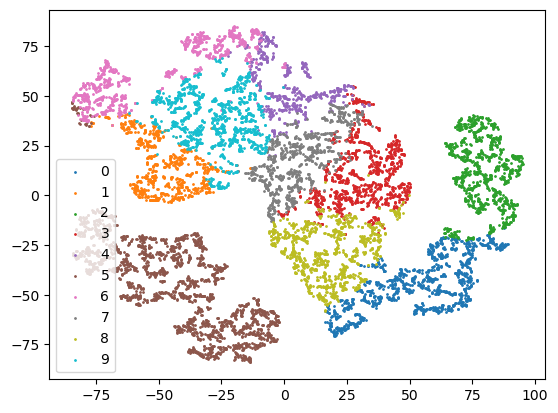

In [17]:
selected_ids = np.random.choice(len(train_dataset), size = 10000)
plot_tsne(labels[selected_ids], features[selected_ids])

In [11]:
train_config = {
    'num_warmup_epochs': 4,
    'num_train_epochs': 20,
    'clustring_loss_type': 'distance_based', # KLDivLoss, distance_based
    'num_workers': 12,
    'batch_size': 1024,
    'num_clusters': 10,
    'update_target_dist_epochs': 5,
    'clustering_loss_coeff': 0.1,
    'device': device
}

model = AE_CNN_1D()
model.to(device)

train_dataset = LabeledGhentDataset(LABELED_DATASET_PATH, transform=torch.tensor, scale=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# Reconstruction loss
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

model, loss, c_loss, cluster_centres \
= train(model, train_dataset, criterion, scheduler, optimizer, train_config)

training: 	 Epoch 1/24


training: 100%|██████████| 172/172 [00:12<00:00, 13.49batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0304
training: 	 Epoch 2/24


training: 100%|██████████| 172/172 [00:13<00:00, 12.74batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0287
training: 	 Epoch 3/24


training: 100%|██████████| 172/172 [00:12<00:00, 13.79batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0270
training: 	 Epoch 4/24


training: 100%|██████████| 172/172 [00:12<00:00, 13.38batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0256
training: 	 Epoch 5/24


training: 100%|██████████| 172/172 [00:26<00:00,  6.45batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0269
Clustering loss: 	 Loss: 0.0464
training: 	 Epoch 6/24


training: 100%|██████████| 172/172 [00:12<00:00, 13.30batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0251
Clustering loss: 	 Loss: 0.0389
training: 	 Epoch 7/24


training: 100%|██████████| 172/172 [00:13<00:00, 13.08batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0241
Clustering loss: 	 Loss: 0.0385
training: 	 Epoch 8/24


training: 100%|██████████| 172/172 [00:13<00:00, 12.50batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0233
Clustering loss: 	 Loss: 0.0378
training: 	 Epoch 9/24


training: 100%|██████████| 172/172 [00:16<00:00, 10.58batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0226
Clustering loss: 	 Loss: 0.0373
training: 	 Epoch 10/24


training: 100%|██████████| 172/172 [00:14<00:00, 11.91batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0220
Clustering loss: 	 Loss: 0.0369
training: 	 Epoch 11/24


training: 100%|██████████| 172/172 [00:13<00:00, 12.91batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0214
Clustering loss: 	 Loss: 0.0365
training: 	 Epoch 12/24


training: 100%|██████████| 172/172 [00:13<00:00, 13.07batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0208
Clustering loss: 	 Loss: 0.0362
training: 	 Epoch 13/24


training: 100%|██████████| 172/172 [00:14<00:00, 12.14batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0202
Clustering loss: 	 Loss: 0.0358
training: 	 Epoch 14/24


training: 100%|██████████| 172/172 [00:14<00:00, 12.27batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0197
Clustering loss: 	 Loss: 0.0354
training: 	 Epoch 15/24


training: 100%|██████████| 172/172 [00:13<00:00, 12.74batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0192
Clustering loss: 	 Loss: 0.0351
training: 	 Epoch 16/24


training: 100%|██████████| 172/172 [00:13<00:00, 12.78batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0187
Clustering loss: 	 Loss: 0.0348
training: 	 Epoch 17/24


training: 100%|██████████| 172/172 [00:12<00:00, 13.27batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0182
Clustering loss: 	 Loss: 0.0345
training: 	 Epoch 18/24


training: 100%|██████████| 172/172 [00:13<00:00, 13.12batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0178
Clustering loss: 	 Loss: 0.0341
training: 	 Epoch 19/24


training: 100%|██████████| 172/172 [00:12<00:00, 13.28batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0173
Clustering loss: 	 Loss: 0.0338
training: 	 Epoch 20/24


training: 100%|██████████| 172/172 [00:13<00:00, 13.20batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0169
Clustering loss: 	 Loss: 0.0336
training: 	 Epoch 21/24


training: 100%|██████████| 172/172 [00:13<00:00, 13.23batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0165
Clustering loss: 	 Loss: 0.0334
training: 	 Epoch 22/24


training: 100%|██████████| 172/172 [00:13<00:00, 12.38batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0161
Clustering loss: 	 Loss: 0.0333
training: 	 Epoch 23/24


training: 100%|██████████| 172/172 [00:12<00:00, 13.44batch/s]


--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0157
Clustering loss: 	 Loss: 0.0331
training: 	 Epoch 24/24


training: 100%|██████████| 172/172 [00:13<00:00, 12.59batch/s]

--- 0 seconds calculation of clustering loss per epoch---
Reconstruction loss: 	 Loss: 0.0154
Clustering loss: 	 Loss: 0.0330
Pretraining complete in 5m 36s


In [12]:
features = extract_features(model, train_dataset, train_config)
kmeans = MiniBatchKMeans(
        n_clusters=train_config['num_clusters'], 
        batch_size=256,
        init_size=3*train_config['num_clusters'], 
        n_init=3)
labels = kmeans.fit_predict(features)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

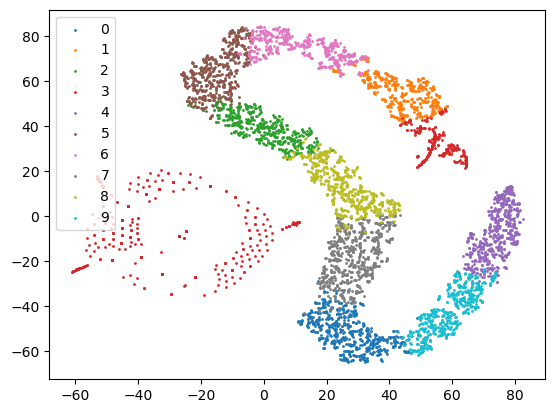

In [13]:
selected_ids = np.random.choice(len(train_dataset), size = 10000)
plot_tsne(labels[selected_ids], features[selected_ids])